# Case Study : Marketing Campaign 
A retailer wants to run a targeted marketing campaign. Their goal is to identify and send $5 to customers who shop inconsistently. 

### Analysis Steps: 
##### Step 1: Calculate the consistency of each customer
##### Step 2: Calculate the value of each customer
##### Step 3: Determine the Target Customer Segement
##### Step 4: Calculate ROI 

In [4]:
# Libs
import pandas as pd
import os
import glob
import matplotlib.pyplot as plt

## Importing and Setting up data

In [5]:
# Loading Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
# use glob to get all the csv files in the folder
path = '/content/drive/MyDrive/Colab Notebooks/Bond Brand - Case Study /dunnhumby_data'
csv_files = glob.glob(os.path.join(path, "*.csv")) 

raw_data = pd.read_csv(csv_files[0])
raw_data.head()

# loop over the list of csv files
for i in range(1,len(csv_files)):
          
    # read the csv file
    df = pd.read_csv(csv_files[i])

    raw_data = pd.concat([raw_data,df], axis = 0, ignore_index= True)


In [7]:
raw_data.shape

(3158469, 22)

## Exploratory Data Analysis

In [8]:
# Looking at data structure 
raw_data.columns

Index(['SHOP_WEEK', 'SHOP_DATE', 'SHOP_WEEKDAY', 'SHOP_HOUR', 'QUANTITY',
       'SPEND', 'PROD_CODE', 'PROD_CODE_10', 'PROD_CODE_20', 'PROD_CODE_30',
       'PROD_CODE_40', 'CUST_CODE', 'CUST_PRICE_SENSITIVITY', 'CUST_LIFESTAGE',
       'BASKET_ID', 'BASKET_SIZE', 'BASKET_PRICE_SENSITIVITY', 'BASKET_TYPE',
       'BASKET_DOMINANT_MISSION', 'STORE_CODE', 'STORE_FORMAT',
       'STORE_REGION'],
      dtype='object')

In [9]:
# Verifying that we have 5000 customers
num_customers = raw_data['CUST_CODE'].nunique()
print(f"There are {num_customers} unique customers")

There are 5000 unique customers


In [10]:
# Dropping transactions without customer code identification
print(f"There are {raw_data['CUST_CODE'].isna().sum()} records without customer code")

There are 617450 records without customer code


In [11]:
# What are various customer life stages
raw_data['CUST_LIFESTAGE'].unique()

array(['OT', 'YF', nan, 'PE', 'OA', 'YA', 'OF'], dtype=object)

In [12]:
raw_data['BASKET_DOMINANT_MISSION'].unique()

array(['Mixed', 'Fresh', 'Grocery', 'XX', 'Nonfood'], dtype=object)

## Data Preprocessing
- Dropping rows where we don't have customer identifiers
- Dropping columns 
    - BASKET_ID, BASKET_PRICE_SENSITIVITY, PROD_CODE, PROD_CODE_10, PROD_CODE_20, PROD_CODE_30, PROD_CODE_40

In [13]:
data = raw_data[raw_data['CUST_CODE'].notna()]
data.shape

(2541019, 22)

In [14]:
data = data.drop(columns = ['BASKET_ID', 'BASKET_PRICE_SENSITIVITY', 'PROD_CODE', 'PROD_CODE_10', 'PROD_CODE_20', 'PROD_CODE_30', 'PROD_CODE_40'])
data.shape

(2541019, 15)

## Step 1: Calculating the consistency of each customer

Clumpiness - Measure of binge-y a customer is. Clumpy customers are more valuable to businesses long-term

In [15]:
data.head()

,SHOP_WEEK,SHOP_DATE,SHOP_WEEKDAY,SHOP_HOUR,QUANTITY,SPEND,CUST_CODE,CUST_PRICE_SENSITIVITY,CUST_LIFESTAGE,BASKET_SIZE,BASKET_TYPE,BASKET_DOMINANT_MISSION,STORE_CODE,STORE_FORMAT,STORE_REGION
0,200607,20060415,7,19,1,0.93,CUST0000410727,UM,OT,L,Full Shop,Mixed,STORE00001,LS,E02
1,200607,20060413,5,20,1,1.03,CUST0000634693,LA,YF,L,Top Up,Fresh,STORE00001,LS,E02
3,200607,20060415,7,19,1,3.07,CUST0000410727,UM,OT,L,Full Shop,Mixed,STORE00001,LS,E02
4,200607,20060415,7,19,1,4.81,CUST0000410727,UM,OT,L,Full Shop,Mixed,STORE00001,LS,E02
5,200607,20060412,4,19,1,0.28,CUST0000634693,LA,YF,M,Small Shop,Fresh,STORE00001,LS,E02


In [16]:
# Sorting data first by Customer Code and then by Shopping Date
data_sorted = data.sort_values(['CUST_CODE', 'SHOP_DATE'])
data_sorted

,SHOP_WEEK,SHOP_DATE,SHOP_WEEKDAY,SHOP_HOUR,QUANTITY,SPEND,CUST_CODE,CUST_PRICE_SENSITIVITY,CUST_LIFESTAGE,BASKET_SIZE,BASKET_TYPE,BASKET_DOMINANT_MISSION,STORE_CODE,STORE_FORMAT,STORE_REGION
1482669,200709,20070423,2,21,1,0.98,CUST0000000013,MM,YF,L,Top Up,Fresh,STORE02747,MS,N03
1482677,200709,20070423,2,21,1,1.34,CUST0000000013,MM,YF,L,Top Up,Fresh,STORE02747,MS,N03
1482680,200709,20070423,2,21,1,2.55,CUST0000000013,MM,YF,L,Top Up,Fresh,STORE02747,MS,N03
1482684,200709,20070423,2,21,1,0.95,CUST0000000013,MM,YF,L,Top Up,Fresh,STORE02747,MS,N03
1482685,200709,20070423,2,21,1,0.97,CUST0000000013,MM,YF,L,Top Up,Fresh,STORE02747,MS,N03
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3029840,200815,20080607,7,18,1,0.91,CUST0000999786,MM,OT,S,Small Shop,Mixed,STORE01125,MS,S02
3029837,200815,20080608,1,15,1,1.32,CUST0000999786,MM,OT,M,Small Shop,Fresh,STORE01125,MS,S02
3029857,200815,20080608,1,15,1,0.49,CUST0000999786,MM,OT,M,Small Shop,Fresh,STORE01125,MS,S02
3029891,200815,20080608,1,15,1,2.22,CUST0000999786,MM,OT,M,Small Shop,Fresh,STORE01125,MS,S02


In [17]:
# 1. Grouping by Cust_Code + Shop_Date to extract full transaction data per customer
# 2. Reset Index because groupby creates multi-index
# 3. Extract Only the Shop_Date, drop all other columns
# 4. Creating column for Transaction Dates
# 5. Creating columns with days between transactions, filling the first transaction NAT with 0

df = data_sorted.groupby(['CUST_CODE', 'SHOP_DATE']).nunique()
df = df.reset_index(level = ['SHOP_DATE']) 
df = df[['SHOP_DATE']]
df['Dates'] = pd.to_datetime(df['SHOP_DATE'], format='%Y%m%d')
df['Days_Between_Transactions'] = df['Dates'] - df['Dates'].shift(1)
df['Days_Between_Transactions'] = df['Days_Between_Transactions'].fillna(pd.Timedelta(seconds=0))
cust_df = df

In [18]:
# Cleaning days between transaction column
cust_df ['Days_Between_Transactions'] = cust_df ['Days_Between_Transactions'].astype(str) 
cust_df ['Days_Between_Transactions'] = cust_df ['Days_Between_Transactions'].replace(r'days', '', regex=True)
cust_df ['Days_Between_Transactions'] = cust_df ['Days_Between_Transactions'].astype(int) 
cust_df

,SHOP_DATE,Dates,Days_Between_Transactions
CUST_CODE,,,
CUST0000000013,20070423,2007-04-23,0
CUST0000000013,20070522,2007-05-22,29
CUST0000000013,20070601,2007-06-01,10
CUST0000000013,20070710,2007-07-10,39
CUST0000000013,20070719,2007-07-19,9
...,...,...,...
CUST0000999786,20080520,2008-05-20,1
CUST0000999786,20080526,2008-05-26,6
CUST0000999786,20080607,2008-06-07,12


In [19]:
# Grouping by customer code and extracting the standard deviation of days between transactions
clump_df = cust_df.groupby(['CUST_CODE']).std()
clump_df = clump_df[['Days_Between_Transactions']]
clump_df = clump_df.rename({'Days_Between_Transactions': 'StdDev_Days_Between_Transactions'}, axis=1)
clump_df

,StdDev_Days_Between_Transactions
CUST_CODE,
CUST0000000013,27.511430
CUST0000000055,134.877193
CUST0000000679,217.491948
CUST0000001052,136.495098
CUST0000001058,108.894444
...,...
CUST0000998609,219.101261
CUST0000998851,60.351841
CUST0000998907,63.117348


(array([2779.,  925.,  315.,  166.,   85.,   41.,   15.,    8.,   12.,
          10.]),
 array([   2.24765725,  116.57419008,  230.9007229 ,  345.22725573,
         459.55378856,  573.88032139,  688.20685421,  802.53338704,
         916.85991987, 1031.18645269, 1145.51298552]),
 <a list of 10 Patch objects>)

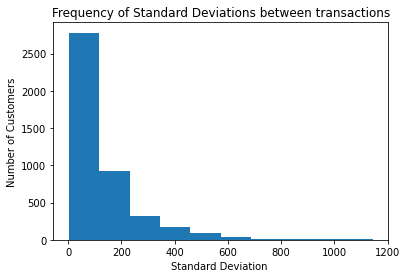

In [20]:
# naming the x axis
plt.xlabel('Standard Deviation ')
# naming the y axis
plt.ylabel('Number of Customers')
# plot title
plt.title('Frequency of Standard Deviations between transactions')
plt.hist(clump_df['StdDev_Days_Between_Transactions'])


## Step 2: Calculating Lifetime Value of each customer
Customer Lifetime Value is the total amount spent by the customer from all their transactions

In [21]:
## Adding customer lifetime value to the clump_df 
# 1. Grouping by Customer Code and aggregating sum of other columns 
# 2. Only keeping customer code and total spend 
clv_df = data_sorted.groupby(['CUST_CODE']).sum()
clv_df = clv_df[['SPEND']]
clv_df

,SPEND
CUST_CODE,
CUST0000000013,160.32
CUST0000000055,433.65
CUST0000000679,85.63
CUST0000001052,260.92
CUST0000001058,71.50
...,...
CUST0000998609,53.86
CUST0000998851,394.92
CUST0000998907,3721.02


(array([3.811e+03, 7.230e+02, 3.090e+02, 1.150e+02, 2.900e+01, 8.000e+00,
        2.000e+00, 0.000e+00, 2.000e+00, 1.000e+00]),
 array([1.0000000e-02, 1.4684150e+03, 2.9368200e+03, 4.4052250e+03,
        5.8736300e+03, 7.3420350e+03, 8.8104400e+03, 1.0278845e+04,
        1.1747250e+04, 1.3215655e+04, 1.4684060e+04]),
 <a list of 10 Patch objects>)

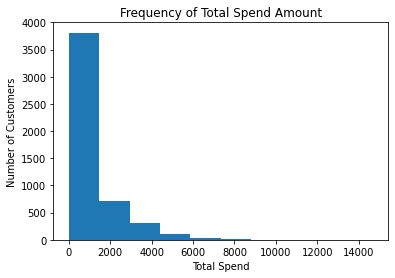

In [22]:
# naming the x axis
plt.xlabel('Total Spend')
# naming the y axis
plt.ylabel('Number of Customers')
# plot title
plt.title('Frequency of Total Spend Amount')
plt.hist(clv_df['SPEND'])

In [23]:
final_df = pd.merge(left = clump_df, right = clv_df, how = 'inner', on= ['CUST_CODE'])
final_df = final_df.rename({'SPEND': 'Total_Spend'}, axis = 1)
final_df

,StdDev_Days_Between_Transactions,Total_Spend
CUST_CODE,,
CUST0000000013,27.511430,160.32
CUST0000000055,134.877193,433.65
CUST0000000679,217.491948,85.63
CUST0000001052,136.495098,260.92
CUST0000001058,108.894444,71.50
...,...,...
CUST0000998609,219.101261,53.86
CUST0000998851,60.351841,394.92
CUST0000998907,63.117348,3721.02


## Step 3: Determine the Target Customer Segement

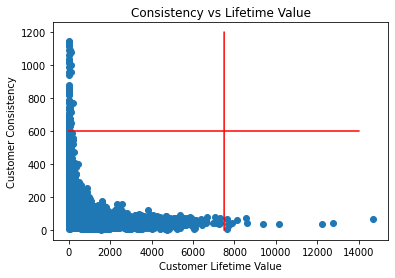

In [24]:
# Creating graph Customer Lifetime Value vs Consistency

plt.scatter(final_df['Total_Spend'], final_df['StdDev_Days_Between_Transactions'])
# naming the x axis
plt.xlabel('Customer Lifetime Value')
# naming the y axis
plt.ylabel('Customer Consistency')
# plot title
plt.title('Consistency vs Lifetime Value')

# Vertical Quadrant Line 
x2 = [7500 for i in range(0,1200,1)]
y2 = [i for i in range(0,1200,1)]
# plotting the line 2 points
plt.plot(x2, y2, color = "red")

# Horizontal Quadrant Line 
x3 = [i for i in range(0,14000,1)]
y3 = [600 for i in range(0,14000,1)]
# plotting the line 2 points
plt.plot(x3, y3, color = "red")

plt.show()



In [25]:
# Lower the Customer Consistency value the better, this means the spread of frequency of visits is less
# Higher CLV means the customer has spent a large amount through their transactions

In [26]:
# Counting number of inconsistent customers
incons_df = final_df[final_df['StdDev_Days_Between_Transactions']>600]
print(f"There are {len(incons_df)} inconsistent customers")

There are 70 inconsistent customers


#### Investigating Inconsistent customers

In [27]:
incons_df

,StdDev_Days_Between_Transactions,Total_Spend
CUST_CODE,,
CUST0000023874,784.181420,2.10
CUST0000025672,632.860569,10.80
CUST0000027294,1145.512986,19.08
CUST0000036781,624.965866,40.09
CUST0000044201,1016.112445,38.66
...,...,...
CUST0000918382,863.377380,4.68
CUST0000942224,781.352993,1.70
CUST0000960491,664.680374,33.09


In [28]:
# Average lifetime spend amongst inconsistent consumers
print(f"Average Total Lifetime Spend: ${incons_df['Total_Spend'].mean()}") 

Average Total Lifetime Spend: $31.77771428571428


In [29]:
incons_custcodes = incons_df.reset_index(drop=False)
incons_custcodes = incons_custcodes[['CUST_CODE']]
incons_custcodes


,CUST_CODE
0,CUST0000023874
1,CUST0000025672
2,CUST0000027294
3,CUST0000036781
4,CUST0000044201
...,...
65,CUST0000918382
66,CUST0000942224
67,CUST0000960491
68,CUST0000981759


In [30]:
incons_merged_df = pd.merge(left = data_sorted, right = incons_custcodes, how = 'inner', on = 'CUST_CODE')
incons_merged_df

,SHOP_WEEK,SHOP_DATE,SHOP_WEEKDAY,SHOP_HOUR,QUANTITY,SPEND,CUST_CODE,CUST_PRICE_SENSITIVITY,CUST_LIFESTAGE,BASKET_SIZE,BASKET_TYPE,BASKET_DOMINANT_MISSION,STORE_CODE,STORE_FORMAT,STORE_REGION
0,200630,20060922,6,19,3,1.05,CUST0000023874,XX,OT,M,Small Shop,Grocery,STORE01071,LS,S01
1,200809,20080427,1,19,3,1.05,CUST0000023874,XX,OT,M,Small Shop,Grocery,STORE01071,LS,S01
2,200617,20060623,6,10,1,0.97,CUST0000025672,XX,OT,M,Small Shop,Fresh,STORE02710,LS,E02
3,200617,20060623,6,10,1,1.87,CUST0000025672,XX,OT,M,Small Shop,Fresh,STORE02710,LS,E02
4,200617,20060623,6,10,1,3.53,CUST0000025672,XX,OT,M,Small Shop,Fresh,STORE02710,LS,E02
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1040,200816,20080613,6,16,1,1.25,CUST0000984478,MM,OT,L,Full Shop,Fresh,STORE02599,LS,W01
1041,200816,20080613,6,16,1,1.24,CUST0000984478,MM,OT,L,Full Shop,Fresh,STORE02599,LS,W01
1042,200816,20080613,6,16,1,1.52,CUST0000984478,MM,OT,L,Full Shop,Fresh,STORE02599,LS,W01
1043,200816,20080613,6,16,1,1.49,CUST0000984478,MM,OT,L,Full Shop,Fresh,STORE02599,LS,W01


In [31]:
print(f"The inconsistent customers spend around ${round(incons_merged_df['SPEND'].mean(),2)} on average per transaction")
print(f"The inconsistent customers spend median: ${round(incons_merged_df['SPEND'].median(),2)}")
print(f"The maximum amount inconsistent customers spend in a given transaction: ${round(incons_merged_df['SPEND'].max(),2)}")
print(f"The minimum amount inconsistent customers spend in a given transaction: ${round(incons_merged_df['SPEND'].min(),2)}")

print(f"Inconsistent customers buy around {int(incons_merged_df['QUANTITY'].mean())} item on average per transaction")
print(f"Inconsistent customers bought a maximum of {int(incons_merged_df['QUANTITY'].max())} items in a transaction")
print(f"Inconsistent customers usually come into the store on the {int(incons_merged_df['SHOP_WEEKDAY'].mean())} day at the {int(incons_merged_df['SHOP_HOUR'].mean())} hour")

The inconsistent customers spend around $2.13 on average per transaction
The inconsistent customers spend median: $1.2
The maximum amount inconsistent customers spend in a given transaction: $89.92
The minimum amount inconsistent customers spend in a given transaction: $0.01
Inconsistent customers buy around 1 item on average per transaction
Inconsistent customers bought a maximum of 16 items in a transaction
Inconsistent customers usually come into the store on the 3 day at the 14 hour


In [32]:
# The majority of inconsistent customers have a lifestage of OT
incons_merged_df['CUST_LIFESTAGE'].value_counts()

OT    883
YF     81
YA     28
PE     24
OA     17
OF     12
Name: CUST_LIFESTAGE, dtype: int64

In [33]:
# The fresh and mixed basket missions are the most commmon
incons_merged_df['BASKET_DOMINANT_MISSION'].value_counts()

Fresh      610
Mixed      331
Grocery     77
Nonfood     25
XX           2
Name: BASKET_DOMINANT_MISSION, dtype: int64

In [34]:
# Inconsistent customers prefer to top up their materials 
incons_merged_df['BASKET_TYPE'].value_counts()

Top Up        527
Full Shop     354
Small Shop    162
XX              2
Name: BASKET_TYPE, dtype: int64

In [35]:
# Inconsistent customers prefer large or medium basket sizes
incons_merged_df['BASKET_SIZE'].value_counts()

L    690
M    305
S     50
Name: BASKET_SIZE, dtype: int64

In [36]:
# Inconsistent customers prefer large size stores
incons_merged_df['STORE_FORMAT'].value_counts()

LS     624
XLS    188
MS     169
SS      64
Name: STORE_FORMAT, dtype: int64

## Calculating ROI 
What would be the result of sending the inconsistent customers the offer. Each customer can only use the offer once.

The retailer wants to send a $5 discount offer: 
- 10% offer response rate

- 5% incremental spend (when a customer uses the offer they spend an extra 5% on transactions)

- Costs the retailer $1 to send the offer

- Costs the retailer $5 when a customer uses the offer

In [37]:
# Inconsistent customers spend around $2.13 on average during transactions
# Since the offer can be only used once, assume that the customer spends $5. 
# With the 5% incremental this becomes $5.25

INVESTMENT_COST = 70*1
NET_RETURNS = (7*5.25) - (70*1) - (7*5)
ROI = ((NET_RETURNS / INVESTMENT_COST) * 100)

print(f"The ROI is {round(ROI,2)} %")

The ROI is -97.5 %


In [38]:
INVESTMENT_COST = 70*0.80
NET_RETURNS = (7*21) - (70*0.80) - (7*5)
ROI = ((NET_RETURNS / INVESTMENT_COST) * 100)

print(f"The ROI is {round(ROI,2)} %")

The ROI is 100.0 %
